In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from neighborhoods import nearest_neighborhood
from datetime import date
from dateutil.relativedelta import relativedelta



In [2]:
df = pd.read_csv('eviction_notices.csv', parse_dates=['File Date'], encoding = "ISO-8859-1")

/Users/jakram/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
len(df)

37736

In [4]:
df.head()

,Eviction ID,Address,City,State,Eviction Notice Source Zipcode,File Date,Non Payment,Breach,Nuisance,Illegal Use,...,Roommate Same Unit,Other Cause,Late Payments,Lead Remediation,Development,Good Samaritan Ends,Constraints Date,Supervisor District,Neighborhoods - Analysis Boundaries,Location
0,M161957,300 Block Of Park Street,San Francisco,CA,94110,2016-06-06,False,False,False,False,...,False,False,False,False,False,False,NaN,9.0,Bernal Heights,"(37.7364374645373, -122.417989910582)"
1,M162256,200 Block Of Seneca Avenue,San Francisco,CA,94112,2016-06-29,False,False,False,False,...,False,False,False,False,False,False,8/25/2021,11.0,Outer Mission,"(37.7205429316262, -122.443264852669)"
2,M162135,200 Block Of Dolores Street,San Francisco,CA,94103,2016-06-28,False,True,False,False,...,False,False,False,False,False,False,NaN,8.0,Castro/Upper Market,"(37.7652067507312, -122.426591617441)"
3,M161901,1200 Block Of 9th Avenue,San Francisco,CA,94122,2016-06-02,False,False,False,False,...,False,False,False,False,False,False,NaN,5.0,Inner Sunset,"(37.764977785911, -122.4664456379)"
4,M162428,1400 Block Of Larkin Street,San Francisco,CA,94109,2016-02-28,False,False,False,False,...,False,False,False,False,False,False,NaN,3.0,Nob Hill,"(37.7912373166567, -122.419197310472)"


In [5]:
df = df.dropna(subset=['Location'])
len(df)

36289

In [6]:
mindate = date(2007, 8, 15) # This is the minimum date for which we have home values from Zillow.
lookbackperiod_mos = 18 # This is the number of lookback months to find change in home values prior to an eviction
df = df[df['File Date'] > (mindate + relativedelta(months=+lookbackperiod_mos)) ]
len(df)

13901

In [7]:
# Function appends data from Zillow API and data file using neighborhood()  
def addPricingData(row, lookback):
    latlng = row['Location']
    lat, lng = latlng.split(',')
    lat = float(lat.replace('(','')) # Reformat lat, lng to separate arguments.
    lng = float(lng.replace(')',''))
    evictdate = row['File Date'].date() # Convert eviction date and create date keys for eviciton date and starting valuation date. 
    startdate = evictdate + relativedelta(months=-lookback)
    evictdate_key = date.strftime(evictdate,"%b%Y")
    evictdateyear = date.strftime(evictdate,"%Y")
    startdate_key = date.strftime(startdate, "%b%Y")
    neighborhood = nearest_neighborhood(lat, lng) # Create neighborhood object for lat, lng.
    name = neighborhood.name
    meanvalue = float(neighborhood.meanvalue)
    evictdatevalue = neighborhood.prices[evictdate_key]
    s = neighborhood.prices[startdate_key]
    c = neighborhood.prices[evictdate_key]
    valueincrease = (c - s)/s
    return pd.Series({'Eviction_id':row['Eviction ID'],'Lat': lat, 'Lng': lng, 'Year': evictdateyear, 'Zillow_Neighborhood':name, 'Z_2017_Value':meanvalue, 'Z_Evict_Date_Value':evictdatevalue, 'Z_Value_Increase':valueincrease}) 
    return name

# Merge the results of our calls to neighborhood() back to our dataframe.
df = df.merge(df.apply(lambda row: addPricingData(row, lookbackperiod_mos), axis = 1), left_on='Eviction ID', right_on='Eviction_id')
df


,Eviction ID,Address,City,State,Eviction Notice Source Zipcode,File Date,Non Payment,Breach,Nuisance,Illegal Use,...,Neighborhoods - Analysis Boundaries,Location,Eviction_id,Lat,Lng,Year,Z_2017_Value,Z_Evict_Date_Value,Z_Value_Increase,Zillow_Neighborhood
0,M161957,300 Block Of Park Street,San Francisco,CA,94110,2016-06-06,False,False,False,False,...,Bernal Heights,"(37.7364374645373, -122.417989910582)",M161957,37.736437,-122.417990,2016,1083700.0,1193000.0,0.093793,Bernal Heights
1,M162256,200 Block Of Seneca Avenue,San Francisco,CA,94112,2016-06-29,False,False,False,False,...,Outer Mission,"(37.7205429316262, -122.443264852669)",M162256,37.720543,-122.443265,2016,814200.0,951300.0,0.170111,Mission Terrace
2,M162135,200 Block Of Dolores Street,San Francisco,CA,94103,2016-06-28,False,True,False,False,...,Castro/Upper Market,"(37.7652067507312, -122.426591617441)",M162135,37.765207,-122.426592,2016,0.0,NaN,NaN,Duboce Triangle
3,M161901,1200 Block Of 9th Avenue,San Francisco,CA,94122,2016-06-02,False,False,False,False,...,Inner Sunset,"(37.764977785911, -122.4664456379)",M161901,37.764978,-122.466446,2016,1154400.0,1362400.0,0.171453,Inner Sunset
4,M162428,1400 Block Of Larkin Street,San Francisco,CA,94109,2016-02-28,False,False,False,False,...,Nob Hill,"(37.7912373166567, -122.419197310472)",M162428,37.791237,-122.419197,2016,1192900.0,1461900.0,0.146858,Nob Hill
5,M161943,300 Block Of Wilde Avenue,San Francisco,CA,94134,2016-06-06,False,False,True,False,...,Visitacion Valley,"(37.7167969475402, -122.403664398767)",M161943,37.716797,-122.403664,2016,689000.0,743500.0,0.129081,Little Hollywood
6,M161986,0 Block Of Fair Avenue,San Francisco,CA,94110,2016-06-13,False,True,False,False,...,Bernal Heights,"(37.7453025419492, -122.419008184627)",M161986,37.745303,-122.419008,2016,1083700.0,1193000.0,0.093793,Bernal Heights
7,M161976,1300 Block Of Market Street,San Francisco,CA,94102,2016-06-13,True,False,False,False,...,Tenderloin,"(37.777083463941, -122.416979326588)",M161976,37.777083,-122.416979,2016,713000.0,812300.0,0.095630,Van Ness - Civic Center
8,M162257,300 Block Of Lombard Street,San Francisco,CA,94133,2016-06-30,False,False,False,False,...,North Beach,"(37.8035109665788, -122.407095028398)",M162257,37.803511,-122.407095,2016,852000.0,952100.0,0.144076,North Waterfront
9,M161838,2800 Block Of Pierce Street,San Francisco,CA,94123,2016-06-01,False,False,False,False,...,Marina,"(37.7961971224445, -122.438753767562)",M161838,37.796197,-122.438754,2016,1732300.0,2104800.0,0.240818,Cow Hollow


In [8]:
df.dtypes

Eviction ID                                    object
Address                                        object
City                                           object
State                                          object
Eviction Notice Source Zipcode                 object
File Date                              datetime64[ns]
Non Payment                                      bool
Breach                                           bool
Nuisance                                         bool
Illegal Use                                      bool
Failure to Sign Renewal                          bool
Access Denial                                    bool
Unapproved Subtenant                             bool
Owner Move In                                    bool
Demolition                                       bool
Capital Improvement                              bool
Substantial Rehab                                bool
Ellis Act WithDrawal                             bool
Condo Conversion            

In [9]:
aggregation = {
    'Owner Move In' : {
        'total_move_in' : 'sum'
    },
    'Condo Conversion' : {
         'total_condo' : 'sum'
    },
    'Ellis Act WithDrawal' : {
         'total_ellis' : 'sum'
    },
    'Eviction ID' : {
        'total_evictions' : 'count'
    },
    'Z_Value_Increase' : {
        'average_value_increase' : 'mean'
    },
    'Z_2017_Value' : {
        'current_value' : 'mean'
    },
    'Z_Evict_Date_Value' :{ 
        'eviction_date_value' : 'mean'
    }
}



In [10]:
# Creating a dataframe to group by neighborhood. 
groupby_hood = df.groupby(['Zillow_Neighborhood']).agg(aggregation).reset_index()

# Adding columns to indicate frequency of certain eviction types.
groupby_hood['pct_move_in'] = groupby_hood[('Owner Move In','total_move_in')]/groupby_hood[('Eviction ID', 'total_evictions')]
groupby_hood['pct_condo'] = groupby_hood[('Condo Conversion','total_condo')]/groupby_hood[('Eviction ID', 'total_evictions')]
groupby_hood['pct_ellis'] = groupby_hood[('Ellis Act WithDrawal','total_ellis')]/groupby_hood[('Eviction ID', 'total_evictions')]
groupby_hood['pct_suspect'] = (groupby_hood[('Owner Move In','total_move_in')] + groupby_hood[('Ellis Act WithDrawal','total_ellis')] + groupby_hood[('Condo Conversion','total_condo')] 
                         )/groupby_hood[('Eviction ID', 'total_evictions')]

# Drop neighborhoods that lack Zillow pricing data.
groupby_hood = groupby_hood.dropna(subset=[('Z_Value_Increase', 'average_value_increase')]).reset_index()
# Drop neighborhoods with small sample sizes.
groupby_hood = groupby_hood[groupby_hood[('Eviction ID', 'total_evictions')] > 40]
# Print data frame. 
groupby_hood


,index,Zillow_Neighborhood,Owner Move In,Condo Conversion,Ellis Act WithDrawal,Eviction ID,Z_Value_Increase,Z_2017_Value,Z_Evict_Date_Value,pct_move_in,pct_condo,pct_ellis,pct_suspect
,,,total_move_in,total_condo,total_ellis,total_evictions,average_value_increase,current_value,eviction_date_value,,,,
0,3,Bayview,35.0,0.0,6.0,303,0.224686,612400.0,6.195523e+05,0.115512,0.000000,0.019802,0.135314
1,4,Bernal Heights,104.0,7.0,67.0,468,0.125660,1083700.0,9.622607e+05,0.222222,0.014957,0.143162,0.380342
2,5,Buena Vista Park,15.0,0.0,14.0,116,0.101903,1304100.0,1.137250e+06,0.129310,0.000000,0.120690,0.250000
3,6,Central Richmond,75.0,2.0,32.0,289,0.128557,1284800.0,1.153490e+06,0.259516,0.006920,0.110727,0.377163
4,7,Central Sunset,78.0,0.0,23.0,220,0.117563,994300.0,9.658918e+05,0.354545,0.000000,0.104545,0.459091
6,11,Corona Heights,18.0,0.0,4.0,70,0.112847,1325400.0,1.126299e+06,0.257143,0.000000,0.057143,0.314286
7,12,Cow Hollow,36.0,5.0,15.0,199,0.080270,1732300.0,1.513142e+06,0.180905,0.025126,0.075377,0.281407
8,13,Crocker Amazon,48.0,0.0,4.0,209,0.164779,724200.0,7.059921e+05,0.229665,0.000000,0.019139,0.248804
10,15,Downtown,4.0,0.0,7.0,408,0.107526,694600.0,6.195583e+05,0.009804,0.000000,0.017157,0.026961


In [11]:
# Creating a dataframe to group by year, then neighborhood. 
groupby_year_hood = df.groupby(['Zillow_Neighborhood', 'Year']).agg(aggregation).reset_index()
# Drop neighborhoods that lack Zillow pricing data.
groupby_year_hood = groupby_year_hood.dropna(subset=[('Z_Value_Increase', 'average_value_increase')]).reset_index()
groupby_year_hood

,index,Zillow_Neighborhood,Year,Owner Move In,Condo Conversion,Ellis Act WithDrawal,Eviction ID,Z_Value_Increase,Z_2017_Value,Z_Evict_Date_Value
,,,,total_move_in,total_condo,total_ellis,total_evictions,average_value_increase,current_value,eviction_date_value
0,24,Bayview,2012,2.0,0.0,0.0,23,-0.118674,612400.0,3.609174e+05
1,25,Bayview,2013,1.0,0.0,0.0,32,0.375125,612400.0,4.898094e+05
2,26,Bayview,2014,2.0,0.0,0.0,38,0.457080,612400.0,6.025658e+05
3,27,Bayview,2015,3.0,0.0,0.0,44,0.300164,612400.0,7.170159e+05
4,28,Bayview,2016,12.0,0.0,3.0,55,0.136513,612400.0,7.561945e+05
5,29,Bayview,2017,9.0,0.0,3.0,34,0.080397,612400.0,8.105294e+05
6,30,Bernal Heights,2009,5.0,0.0,2.0,31,-0.158236,1083700.0,6.743387e+05
7,31,Bernal Heights,2010,4.0,0.0,2.0,41,0.012995,1083700.0,7.198537e+05
8,32,Bernal Heights,2011,11.0,0.0,4.0,56,0.013448,1083700.0,6.993607e+05


In [12]:
# Creating a dataframe to group by year, then neighborhood. 
groupby_year = df.groupby(['Year']).agg(aggregation).reset_index()
# Drop neighborhoods that lack Zillow pricing data.
groupby_year = groupby_year.dropna(subset=[('Z_Value_Increase', 'average_value_increase')]).reset_index()
groupby_year

,index,Year,Owner Move In,Condo Conversion,Ellis Act WithDrawal,Eviction ID,Z_Value_Increase,Z_2017_Value,Z_Evict_Date_Value
,,,total_move_in,total_condo,total_ellis,total_evictions,average_value_increase,current_value,eviction_date_value
0,0,2009,104.0,1.0,36.0,1001,-0.153167,940783.116883,7.234148e+05
1,1,2010,117.0,4.0,68.0,1322,-0.062871,775508.245083,7.656215e+05
2,2,2011,124.0,2.0,54.0,1265,-0.020650,884156.996047,7.682928e+05
3,3,2012,171.0,11.0,99.0,1601,0.043501,846902.435978,8.031838e+05
4,4,2013,272.0,11.0,231.0,1823,0.246365,903660.120680,9.321901e+05
5,5,2014,311.0,10.0,100.0,1914,0.259405,961753.396029,1.113736e+06
6,6,2015,419.0,18.0,146.0,2052,0.229440,991103.167641,1.258890e+06
7,7,2016,397.0,5.0,145.0,2096,0.115226,796989.933206,1.232897e+06
8,8,2017,186.0,3.0,98.0,827,0.039640,945937.847642,1.277097e+06


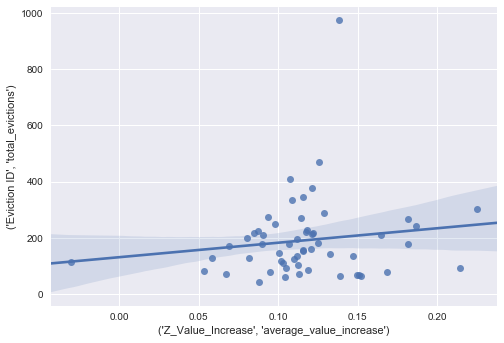

In [13]:
ax = sns.regplot(y=groupby_hood[('Eviction ID', 'total_evictions')], x=groupby_hood[('Z_Value_Increase', 'average_value_increase')], data=groupby_hood)
plt.show()

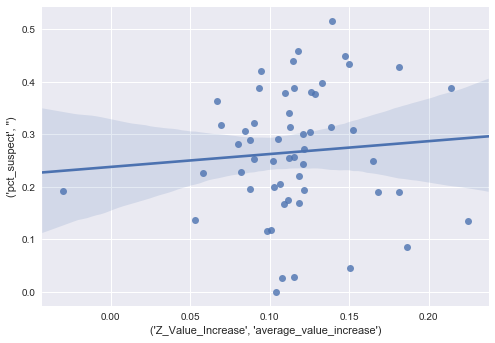

In [14]:
ax = sns.regplot(y=groupby_hood[('pct_suspect', '')], x=groupby_hood[('Z_Value_Increase', 'average_value_increase')], data=groupby_hood)
plt.show()

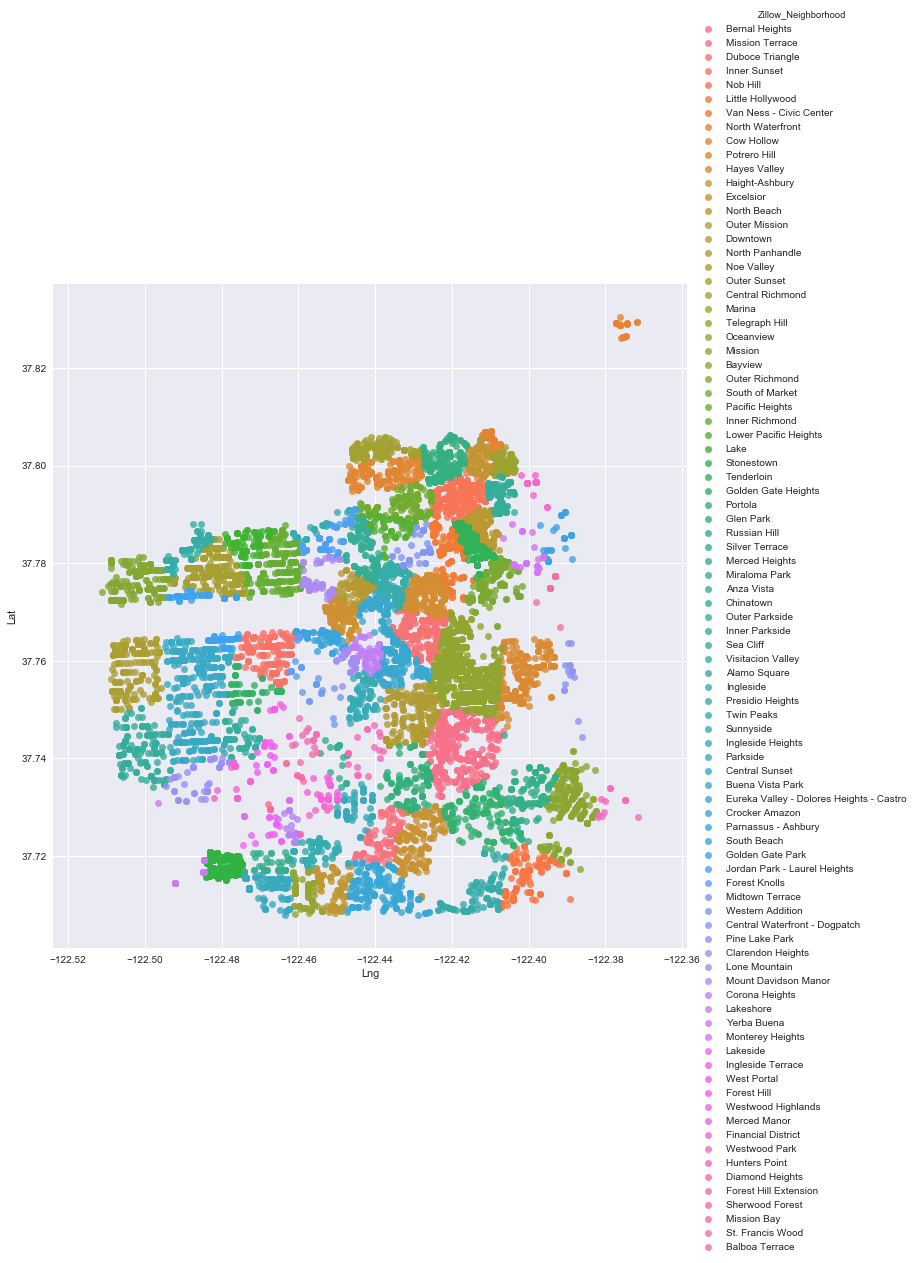

In [15]:
ax = sns.lmplot(x='Lng', y='Lat', hue='Zillow_Neighborhood', size=10, data=df, fit_reg=False, legend_out=True)
# ax.set_xlim(-122.55,-122.35)
# ax.set_ylim(37.7,37.81)
plt.show()

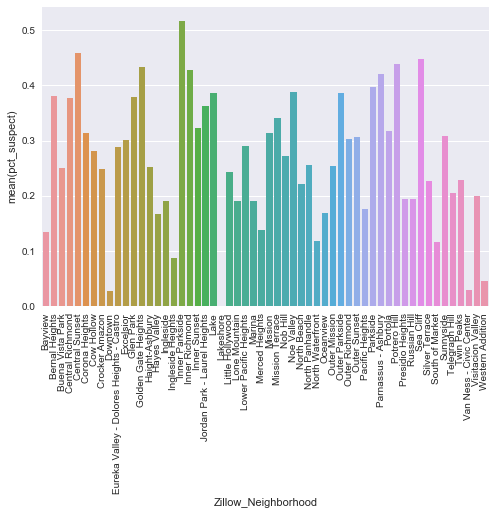

In [16]:
ax = sns.barplot(x='Zillow_Neighborhood', y='pct_suspect', data=groupby_hood)
ax.set_xticklabels(labels=groupby_hood['Zillow_Neighborhood'], rotation=90)
plt.show()